Uses [sqlglot](https://github.com/tobymao/sqlglot) to extract all tables referenced in a given SQL query.
Adds these tables as a List[str] feature in the `table_id` column of the spider and bird datasets.

In [1]:
!pip install sqlglot
!pip install seaborn
!pip install matplotlib

In [3]:
from typing import List, Dict, Literal
import datasets
from tqdm.notebook import tqdm
from sqlglot import parse_one, exp
from sqlglot.optimizer.scope import build_scope

In [4]:
def get_tables(sql: str) -> List[str]:
    # https://github.com/tobymao/sqlglot/blob/main/posts/ast_primer.md
    ast = parse_one(sql)
    root = build_scope(ast)
    table_nodes: List[exp.Table] = [source for scope in root.traverse() for alias, (node, source) in scope.selected_sources.items() if isinstance(source, exp.Table)]
    return [n.name for n in table_nodes]

In [5]:
task_to_split_to_processed_dataset: Dict[str, Dict[Literal['train', 'test', 'validation'], datasets.Dataset]] = {}
for task in ["spider", "bird"]:
    task_to_split_to_processed_dataset[task] = {}
    for split in ["train", "test", "validation"]:
        dataset = datasets.load_dataset(f"target-benchmark/spider-queries-{split}")[split]
        all_table_names = []
        for idx, item in enumerate(tqdm(dataset, total=len(dataset), desc=f"{task} - {split}...")):
            table_names = get_tables(item['answer'])
            if len(table_names) == 0:
                print(split)
                print(idx)
                print(item['answer'])
                raise ValueError
            all_table_names.append(table_names)
        # Remove, then add `table_id`
        # This will be of type datasets.Sequence(datasets.Value("string")
        dataset = dataset.remove_columns("table_id")
        dataset = dataset.add_column(
            name="table_id",
            column=all_table_names,
        )
        task_to_split_to_processed_dataset[task][split] = dataset

spider - train...:   0%|          | 0/6997 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

spider - test...:   0%|          | 0/2147 [00:00<?, ?it/s]

spider - validation...:   0%|          | 0/1034 [00:00<?, ?it/s]

bird - train...:   0%|          | 0/6997 [00:00<?, ?it/s]

bird - test...:   0%|          | 0/2147 [00:00<?, ?it/s]

bird - validation...:   0%|          | 0/1034 [00:00<?, ?it/s]

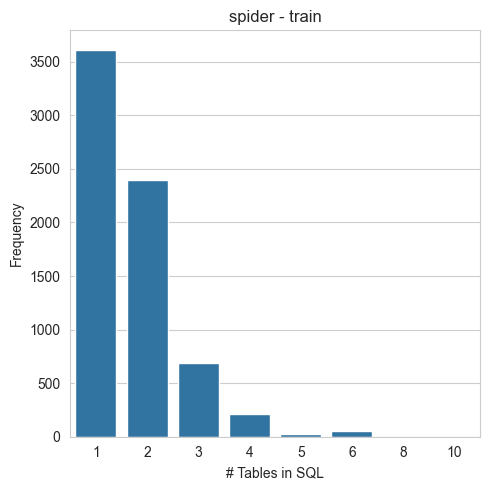

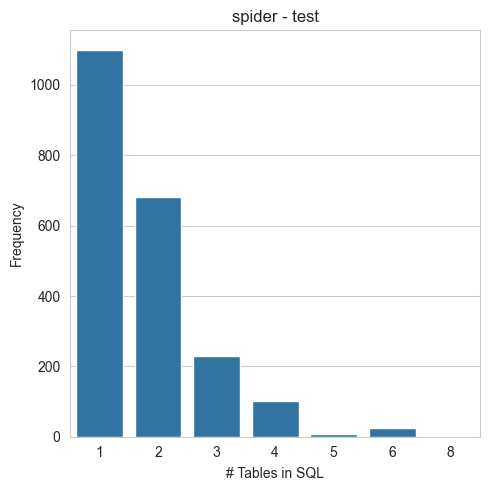

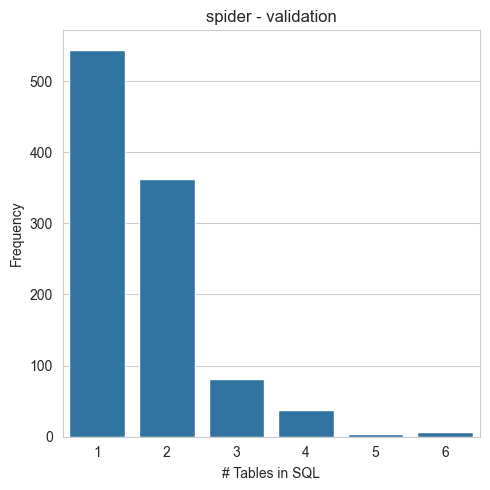

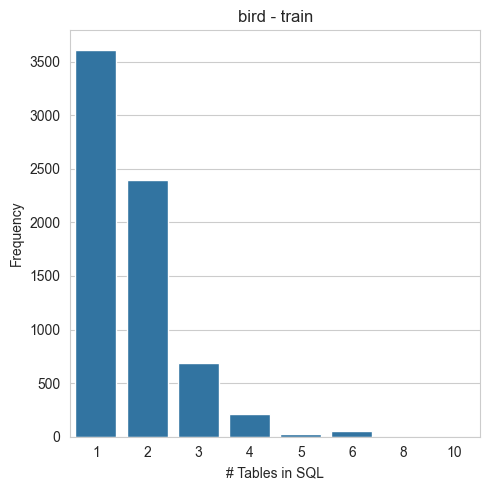

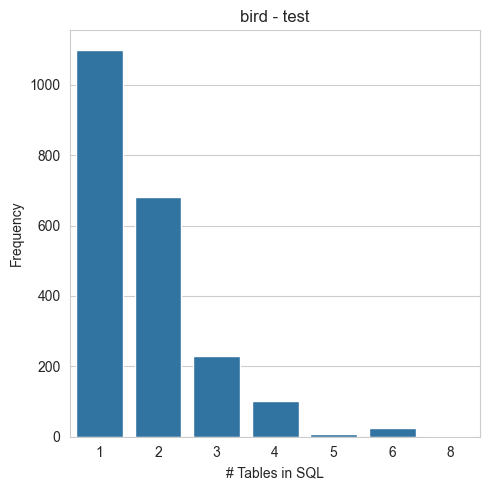

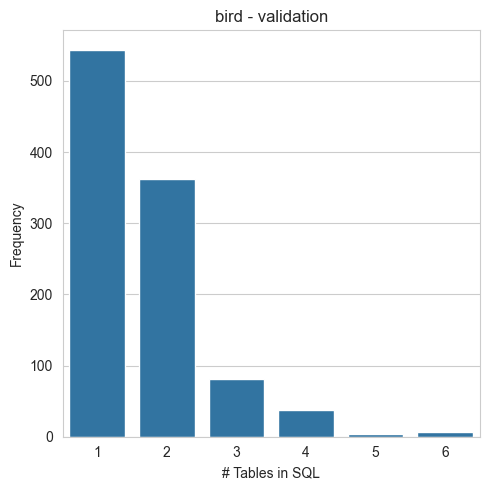

In [31]:
# What's the distribution of # of tables like?
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from collections import Counter

for task, split_to_dataset in task_to_split_to_processed_dataset.items():
    for split, dataset in split_to_dataset.items():
        num_tables = [len(item['table_id']) for item in dataset]
        df = pd.DataFrame.from_dict(Counter(num_tables), orient='index', columns=['Frequency']).reset_index().rename(columns={"index": "# Tables in SQL"})
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.barplot(df, x="# Tables in SQL", y="Frequency")
        plt.title(f"{task} - {split}")
        plt.tight_layout()
        plt.show()

In [16]:
# Some of the queries can get crazy - up to 8 tables mentioned!
task_to_split_to_processed_dataset['spider']['test'][589]['answer']

'SELECT T4.title FROM Orders AS T1 JOIN Books_Order AS T2 ON T1.idOrder  =  T2.idOrder JOIN Client AS T3 ON T1.idClient  =  T3.idClient JOIN book AS T4 ON T2.ISBN  =  T4.isbn WHERE T3.name  =  "Peter Doe" EXCEPT SELECT T4.title FROM Orders AS T1 JOIN Books_Order AS T2 ON T1.idOrder  =  T2.idOrder JOIN Client AS T3 ON T1.idClient  =  T3.idClient JOIN book AS T4 ON T2.ISBN  =  T4.isbn WHERE T3.name  =  "James Smith"'

In [6]:
# Save to csv files
for task, split_to_dataset in task_to_split_to_processed_dataset.items():
    for split, dataset in split_to_dataset.items():
        dataset.to_csv(f"{task}-queries-{split}-with-table-id.csv")

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

Creating CSV from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]